Import Libraries

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package stopwords to C:\Users\LAzY
[nltk_data]     BUGzzz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LAzY
[nltk_data]     BUGzzz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LAzY
[nltk_data]     BUGzzz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LAzY
[nltk_data]     BUGzzz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\LAzY
[nltk_data]     BUGzzz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LAzY BUGzzz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is alread

True

In [10]:
# Data Handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Text Processing
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [11]:

df = pd.read_csv("Data/amazon_alexa.tsv", sep="\t")

In [12]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [14]:
df.columns


Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [15]:
df['feedback'].value_counts()


feedback
1    2893
0     257
Name: count, dtype: int64

In [16]:
df['feedback'] = df['feedback'].map({1: 'Positive', 0: 'Negative'})


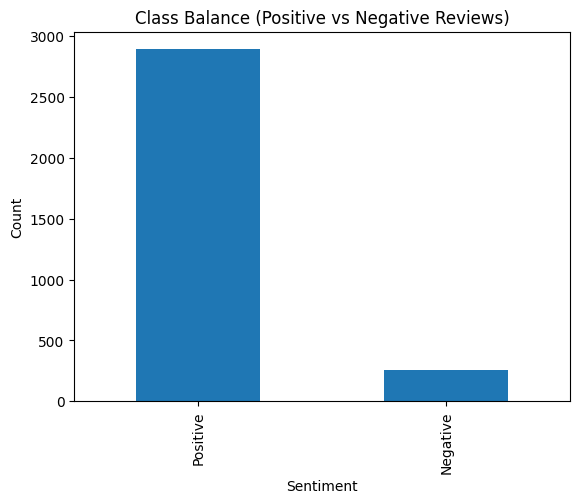

In [17]:
df['feedback'].value_counts().plot(kind='bar')
plt.title("Class Balance (Positive vs Negative Reviews)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

OverSampling the Imabalance Data

In [18]:
# Separate majority (Positive) and minority (Negative)
df_majority = df[df['feedback'] == 'Positive']
df_minority = df[df['feedback'] == 'Negative']

# Oversample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,                     # sample with replacement
    n_samples=len(df_majority),       # match majority count
    random_state=42                   # reproducibility
)

# Combine majority with upsampled minority
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class balance
print(df_balanced['feedback'].value_counts())


feedback
Negative    2893
Positive    2893
Name: count, dtype: int64


Lowercasing

In [19]:
df["lower_text"] = df["verified_reviews"].str.lower()
df[["verified_reviews", "lower_text"]].head(5)

,verified_reviews,lower_text
0,Love my Echo!,love my echo!
1,Loved it!,loved it!
2,"Sometimes while playing a game, you can answer...","sometimes while playing a game, you can answer..."
3,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing. my 4 ...
4,Music,music


Remove Numbers

In [20]:
df["rem_numbers"] = df["lower_text"].apply(
    lambda x: re.sub(r"\d+", "", str(x)) if pd.notnull(x) else ""
)
df[["lower_text", "rem_numbers"]]

,lower_text,rem_numbers
0,love my echo!,love my echo!
1,loved it!,loved it!
2,"sometimes while playing a game, you can answer...","sometimes while playing a game, you can answer..."
3,i have had a lot of fun with this thing. my 4 ...,i have had a lot of fun with this thing. my y...
4,music,music
...,...,...
3145,"perfect for kids, adults and everyone in betwe...","perfect for kids, adults and everyone in betwe..."
3146,"listening to music, searching locations, check...","listening to music, searching locations, check..."
3147,"i do love these things, i have them running my...","i do love these things, i have them running my..."
3148,only complaint i have is that the sound qualit...,only complaint i have is that the sound qualit...


Remove Punctuation

In [21]:
df["no_punct"] = df["rem_numbers"].apply(
    lambda x: str(x).translate(str.maketrans("", "", string.punctuation))
)

Tokenization

In [22]:
df["tokens"] = df["no_punct"].apply(
    lambda x: nltk.word_tokenize(str(x))
)
df[["no_punct", "tokens"]].head(5)

,no_punct,tokens
0,love my echo,"[love, my, echo]"
1,loved it,"[loved, it]"
2,sometimes while playing a game you can answer ...,"[sometimes, while, playing, a, game, you, can,..."
3,i have had a lot of fun with this thing my yr...,"[i, have, had, a, lot, of, fun, with, this, th..."
4,music,[music]


Remove Stopwords

In [23]:
stop_words = set(stopwords.words("english"))
df["rem_stopwords"] = df["tokens"].apply(
    lambda tokens: [w for w in tokens if w.lower() not in stop_words]
)
df[["tokens", "rem_stopwords"]].head(5)


,tokens,rem_stopwords
0,"[love, my, echo]","[love, echo]"
1,"[loved, it]",[loved]
2,"[sometimes, while, playing, a, game, you, can,...","[sometimes, playing, game, answer, question, c..."
3,"[i, have, had, a, lot, of, fun, with, this, th...","[lot, fun, thing, yr, old, learns, dinosaurs, ..."
4,[music],[music]


Lemmatization

In [24]:
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
df["lemmatized"] = df["rem_stopwords"].apply(
    lambda tokens: [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
)

df[["rem_stopwords", "lemmatized"]].head(10)

,rem_stopwords,lemmatized
0,"[love, echo]","[love, echo]"
1,[loved],[love]
2,"[sometimes, playing, game, answer, question, c...","[sometimes, play, game, answer, question, corr..."
3,"[lot, fun, thing, yr, old, learns, dinosaurs, ...","[lot, fun, thing, yr, old, learns, dinosaur, c..."
4,[music],[music]
5,"[received, echo, gift, needed, another, blueto...","[receive, echo, gift, need, another, bluetooth..."
6,"[without, cellphone, use, many, features, ipad...","[without, cellphone, use, many, feature, ipad,..."
7,"[think, th, one, ive, purchased, im, working, ...","[think, th, one, ive, purchase, im, work, get,..."
8,"[looks, great]","[look, great]"
9,"[love, ’, listened, songs, ’, heard, since, ch...","[love, ’, listen, song, ’, heard, since, child..."


Save Processed Dataset

In [25]:
df.to_csv("processed_data.csv", index=False)

Import Porcessed_Data

In [26]:
df = pd.read_csv("processed_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   object
 5   lower_text        3149 non-null   object
 6   rem_numbers       3149 non-null   object
 7   no_punct          3149 non-null   object
 8   tokens            3150 non-null   object
 9   rem_stopwords     3150 non-null   object
 10  lemmatized        3150 non-null   object
dtypes: int64(1), object(10)
memory usage: 270.8+ KB


Token-to-Text Conversion

In [27]:
def text(tokens):
    if isinstance(tokens, list):
        return ' '.join([str(token) for token in tokens if token and str(token).strip()])
    elif isinstance(tokens, str):
        return tokens
    else:
        return ''

df["cleaned_text"] = df["lemmatized"].apply(text)

In [28]:
print(df["cleaned_text"].head())
print("Unique words:", len(df["cleaned_text"].str.split().explode().unique()))

0                                     ['love', 'echo']
1                                             ['love']
2    ['sometimes', 'play', 'game', 'answer', 'quest...
3    ['lot', 'fun', 'thing', 'yr', 'old', 'learns',...
4                                            ['music']
Name: cleaned_text, dtype: object
Unique words: 4424


TF-IDF

In [29]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  
    min_df=2,           
    max_df=0.95   
)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF matrix shape: (3150, 2007)
Vocabulary size: 2007


Train-Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,                # TF-IDF features
    df['feedback'],         # sentiment labels
    test_size=0.2,          # 20% for testing, 80% for training
    random_state=42,        # Same random split every time
    stratify=df['feedback'] # Keep same class balance in both sets
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 2520
Testing samples: 630


Logistic Regression Model

In [31]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


Evaluate Model Performance

In [32]:
# Predict on test data
y_pred = lr_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Detailed performance report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Accuracy: 92.06%
Classification Report
              precision    recall  f1-score   support

    Negative       1.00      0.02      0.04        51
    Positive       0.92      1.00      0.96       579

    accuracy                           0.92       630
   macro avg       0.96      0.51      0.50       630
weighted avg       0.93      0.92      0.88       630

Confusion Matrix
[[  1  50]
 [  0 579]]


Model did not give satisfied result for negative reviews. SO we will do Oversampling on train data

In [33]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_tfidf, 
    df['feedback'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['feedback']
)

SMOTE

In [34]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_temp, y_temp)

print("Training data balanced with SMOTE!")
print(f"Training: {X_train.shape}, Testing: {X_test.shape}")

Training data balanced with SMOTE!
Training: (4628, 2007), Testing: (630, 2007)


Again Logistic Regression Model

In [35]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
print("Logistic Regression trained!")

Logistic Regression trained!


New Evaluation

In [36]:
y_pred = lr_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 87.14%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.37      0.82      0.51        51
    Positive       0.98      0.88      0.93       579

    accuracy                           0.87       630
   macro avg       0.68      0.85      0.72       630
weighted avg       0.93      0.87      0.89       630



Naive Bayes

In [37]:
# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

print("NAIVE BAYES PERFORMANCE:")
print(f"Accuracy: {accuracy_score(y_test, nb_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, nb_pred))

NAIVE BAYES PERFORMANCE:
Accuracy: 88.73%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.80      0.54        51
    Positive       0.98      0.89      0.94       579

    accuracy                           0.89       630
   macro avg       0.69      0.85      0.74       630
weighted avg       0.93      0.89      0.90       630



Word Clouds Visualization

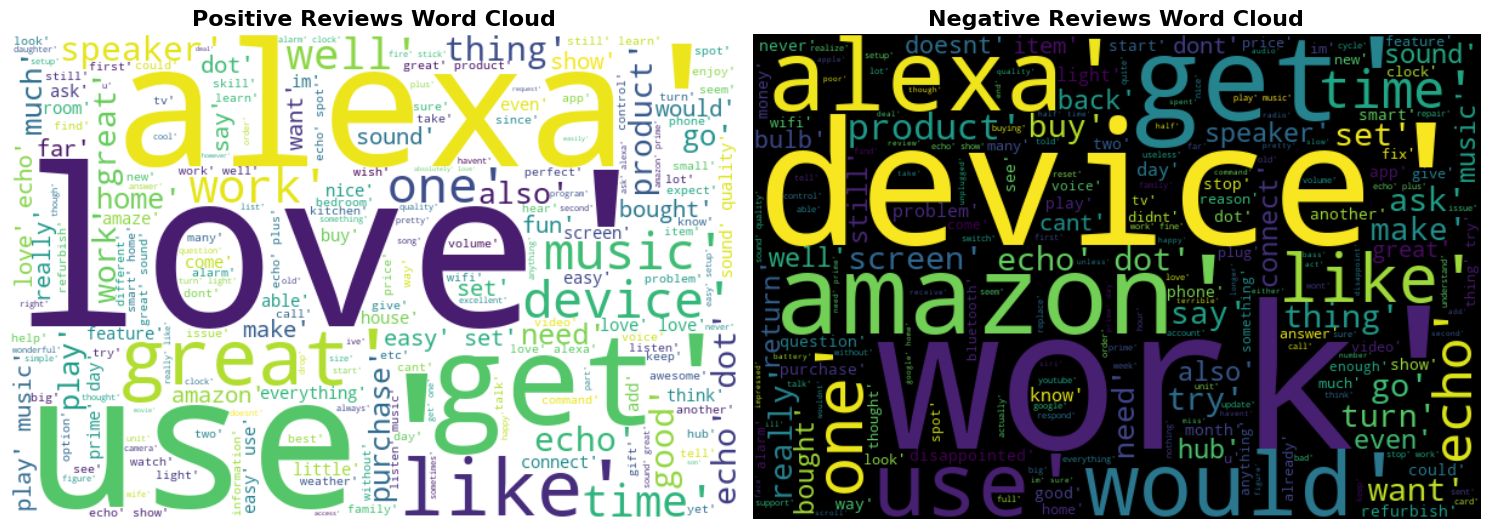

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word clouds
positive_text = ' '.join(df[df['feedback']=='Positive']['lemmatized'])
negative_text = ' '.join(df[df['feedback']=='Negative']['lemmatized'])

# Generate word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Positive words
wordcloud_pos = WordCloud(width=600, height=400, background_color='white').generate(positive_text)
ax1.imshow(wordcloud_pos, interpolation='bilinear')
ax1.set_title('Positive Reviews Word Cloud', fontsize=16, fontweight='bold')
ax1.axis('off')

# Negative words  
wordcloud_neg = WordCloud(width=600, height=400, background_color='black').generate(negative_text)
ax2.imshow(wordcloud_neg, interpolation='bilinear')
ax2.set_title('Negative Reviews Word Cloud', fontsize=16, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [39]:
print(df.columns.tolist())

['rating', 'date', 'variation', 'verified_reviews', 'feedback', 'lower_text', 'rem_numbers', 'no_punct', 'tokens', 'rem_stopwords', 'lemmatized', 'cleaned_text']


Model Comparison

In [40]:
print("FINAL MODEL COMPARISON:")
print(f"Logistic Regression: {accuracy_score(y_test, y_pred):.2%}")
print(f"Naive Bayes: {accuracy_score(y_test, nb_pred):.2%}")

if accuracy_score(y_test, y_pred) > accuracy_score(y_test, nb_pred):
    print("Logistic Regression performed better!")
else:
    print("Naive Bayes performed better!")

FINAL MODEL COMPARISON:
Logistic Regression: 87.14%
Naive Bayes: 88.73%
Naive Bayes performed better!
